## Prototypical GA applied to the TSP V2

This prototypical GA aims to solve the travelling salesman problem for fully connected graphs without self-connections where each node must be visited exactly once with no requirement to return to the source node. 

V2 provides slightly tidier code as compared with the original implementation. 

In [122]:
import random
import numpy as np
import networkx as nx
from statistics import mean

In [120]:
def path_length(p, g):
    return sum(g[i][j]['weight'] for i, j in zip(p, p[1:]))

In [118]:
# Fitness function is the inverse of the pathlength 
def fit(h, g):
    return (1 / path_length(h, g))

In [77]:
# Define a population generation method 
# For the TSP every node must be visisted at least once 
# The nodes can be visited in any order without a specific source node 
def gen_population(size, g):
    nodes = list(g.nodes())
    return np.array([np.random.permutation(nodes) for x in range(size)])

In [78]:
# The prototypical mutation scheme is to invert a random bit from a gene
#              selected uniformly 
# In this case, we need sequences of nodes without duplicates 
# The mutation scheme here will be to swap the index of two nodes, chosen uniformly 
def mutate(h):
    # Uniformly select two values from np.arrange(0, len(h))
    a, b = tuple(np.random.choice(len(h), 2))
    # Swap these values 
    h[a], h[b] = h[b], h[a]
    
    return h 

In [79]:
# Order 1 Crossover (OX1)
# OX1 produces two combinations without duplicates 
#    where elements taken maintain their ordering in the parent
# 
# Elements from a random index range are taken and put into the child 
#    then remaining (unique) values from the alternate parent are inserted
#    to the empty indexes in the child in the order they appear in the parent 
# 
# E.g. [a, b, c, d, e, f] x [e, b, a, c, d, f]
# Index range 1 - 3 
# Child a: [0, b, c, d, 0, 0]
# Child b: [0, b, a, c, 0, 0]
#
# Add elements from alternate parent in order 
# Child a: [e, b, c, d, a, f]
# Child b: [d, b, a, c, e, f]

def crossover(a, b):
    # Select two random indexes 
    x, y = np.random.choice(len(a), 2)
    
    if x > y: 
        x, y = y, x # Enforce x < y 
    
    # Create an empty array 
    child_a = [None] * len(a)
    child_b = [None] * len(a)
    
    # Insert elements from index range into each child 
    child_a[x:(y+1)] = a[x:(y+1)]
    child_b[x:(y+1)] = b[x:(y+1)]
    
    # List empty indexes in children 
    ix = list(range(0, x)) + list(range((y + 1), len(a)))
    
    # Insert elements from Parent B into Child A 
    ind = 0
    for gene in b:
        if gene not in child_a:
            child_a[ix[ind]] = gene   # Insert missing gene at next empty index
            ind += 1 
    
    # Insert elements from Parent A into Child B 
    ind = 0 
    for gene in a:
        if gene not in child_b:
            child_b[ix[ind]] = gene   # Insert missing gene at next empty index 
            ind +=1 

    return child_a, child_b

In [115]:
# Compute the fitness value of each hypotheses 
# p: Population
# g: Graph 
# Return: fitness list, maximum fitness value, sum of fitness values 
def evaluate(p, g):
    # Evaluate the fitness of the population 
    fitness = [fit(h, g) for h in p]

    return fitness, max(fitness), sum(fitness), mean(fitness)

In [81]:
# Stochastic universal selection 
#     - Uses a single random value to sample all solutions 
# n: Number of hypotheses to select
# population: Population of hypotheses
# fitness: Fitness array
# ftotal: Sum of fitness values 
# target: Target array to append selected hypotheses 
def stochastic_universal(n, population, fitness, ftotal, target):
    step = ftotal / n                       # Size of selection bins 
    start = random.uniform(0, step)     # Random in range [0, step)
    
    # Each pointer value indicates a selection threshold
    # When the sum of probabilities exceeds a pointer, the current hypotheses is selected 
    pointers = [(start + (i * step)) for i in range(0, n)]
    
    for ptr in pointers:
        ind = 0               # Current index 
        running_sum = 0.0       # Sum of probabilities (fit(h) / total_fitness)
        
        # Until the threshold is exceeded 
        while running_sum < ptr: 
            running_sum += fitness[ind]
            ind += 1 
        
        target.append(population[ind - 1])

In [153]:
# p: size of population 
# r: fraction of population to be replaced by crossover 
# m: mutation rate 
# g; graph 
def ga(threshold, itr, p, r, m, g):
    history = []

    # Generate a random population 
    population = gen_population(p,g)
    fitness, fmax, ftotal, favg = evaluate(population, g)
        
    # Generations 
    count = 0
    while  (fmax < threshold) and (count < itr):   
        # Append to training history 
        history.append((fmax, favg, ftotal))
        
        # Create new generation 
        gen = []
        
        # Select ((1 - r) * p) hypotheses to persist into the next generation
        # Hypotheses are selected with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        num_hypotheses = int((1 - r) * p)
        stochastic_universal(num_hypotheses, population, fitness, ftotal, gen)
        
        # Select (r * p) / 2 pairs of parents for crossover 
        # Parent hypotheses are chosen with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        parents = [] 
        num_parents = int(r * p) 
        stochastic_universal(num_parents, population, fitness, ftotal, parents)
        
        # Crossover pairs of parents 
        pairs = zip(parents, parents[1:])  # Zip into pairs [1, 2, 3] -> (1, 2), (2, 3)
        for a, b in pairs:
            c, d = crossover(a, b)   # Crossover parents a,b to get children c,d 
            gen.append(c) 
            gen.append(d)
        
        # Choose m percent of new population uniformly to mutate 
        m_size = int(m * p)
        for i in np.random.choice(len(gen), m_size):
            gen[i] = mutate(gen[i])
        
        # Population equal to copy of generation 
        population = list(gen) 
        
        # Evaluate the current population fitness
        fitness, fmax, ftotal, favg = evaluate(population, g)
        
        # Increment generation count
        count += 1 
    
    # Return best
    final_best = np.argmax(fitness)
    return history, fitness[final_best], population[final_best]

**Expriment 1: Ring Lattice (NetworkX)**
The purpose of this test will be to vidsually evaluate the shortest-pathfinding accuracy of the genetic algorithm using a graph generated with NetworkX. 
- Generate a ring lattice topology with k=2 (each node is connected with its adjacent neighbours) 
- Give each edge in the ring weight 1
- Then, add edges until the graph is fully connected, giving each new edge weight 100
- Plot the points in the ring (only ring k=2)
- Plot the path found by the GA 
    - How efficient is that path? How many wasted connections are used?
    - The optimal path for TSP about the ring is to follow the original ring structure 

In [83]:
# Return every adjacent pair / edge in the ring lattice 
#       structure 
def adjacents(nodes, k):
    hk = int(np.floor(k / 2))
    
    edges = []
    for node in nodes:
        # Identify each adjacent node 
        for j in range((node + 1), (node + hk + 1)):
            v = nodes[j % len(nodes)]  # Modulo enforces loop back to start node  
            edges.append((node, v))
    
    return edges

In [84]:
# Function to produce a ring lattice in NetworkX
def ring_lattice(n, k):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(adjacents(range(n), k))
    return G 

In [85]:
# Function to add remaining edges 
def fully_connect_ring(G, w):
    n = G.number_of_nodes() 
    
    for i in range(n):
        for j in range(n):
            if (i == j):
                continue 
            elif G.has_edge(i, j):
                continue
            else:
                G.add_edge(i, j, weight = w)

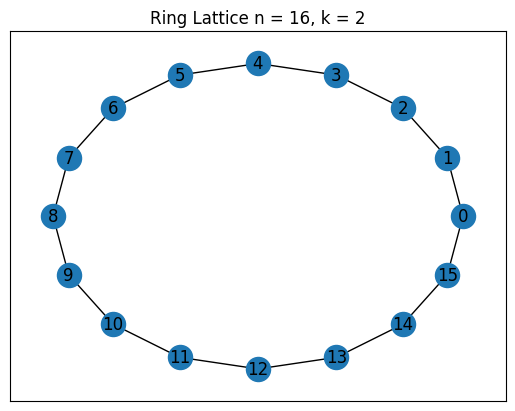

In [165]:
import matplotlib.pyplot as plt 

# Test this
ring = ring_lattice(16, 2)
ring_edges = [e for e in ring.edges]

# Set weights 
nx.set_edge_attributes(ring, values = 0, name = 'weight')

# Define plot layout 
layout = nx.circular_layout(ring)

# Plot ring 
plt.figure()
nx.draw_networkx_nodes(ring, pos = layout)
nx.draw_networkx_edges(ring, pos = layout, edgelist = ring.edges())
# Node labels
nx.draw_networkx_labels(ring, layout, font_size=12, font_family="sans-serif")
# Title
plt.title("Ring Lattice n = 16, k = 2")
plt.show()

# Fully connect ring (add edges between all nodes)
fully_connect_ring(ring, 100)

# GA Hyperparameters 
THRESHOLD = 1    # Fitness threshold (1 / length-of-optimal-path)
ITERATIONS = 500        # Maximum iterations before exit ga
P_SIZE = 100            # Size of population 
M_RATE = 0.01           # Mutation rate (percent of population to mutate)
R_RATE = 0.5           # Reproduction rate (percent of pop. to select as parents)

history, best_fit, best_solution = ga(THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, ring)

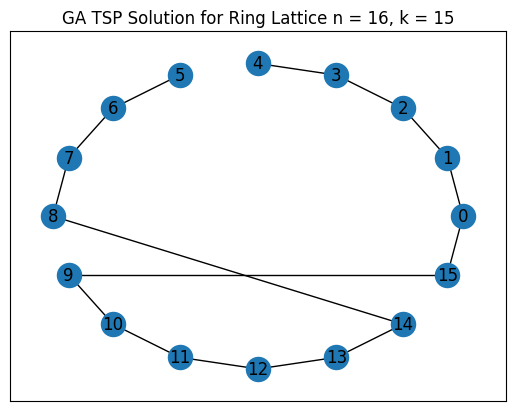

In [166]:
# Plot GA-SP solut
plt.figure()
nx.draw_networkx_nodes(ring, pos = layout)
nx.draw_networkx_edges(ring, pos = layout, edgelist = list(zip(best_solution, best_solution[1:])))
# Node labels
nx.draw_networkx_labels(ring, layout, font_size=12, font_family="sans-serif")
# Title 
plt.title("GA TSP Solution for Ring Lattice n = 16, k = 15")
plt.show()

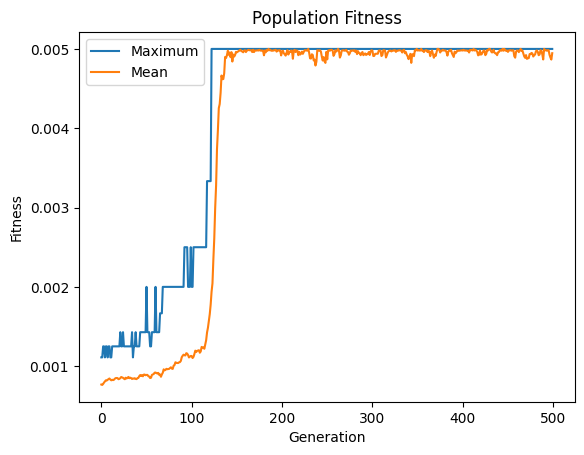

In [167]:
Genetic Algorithms are based on biological evolution. By the algorithmic processes of selection, crossover and mutation, components of candidate solutions are combined to produce new solutions where the aim is to improve the fitness of the population with each generation. \\

In simple terms, the GA process is as follows: 
\begin{enumerate}
	\item Initialise a population of candidate solutions stochastically 
	\item Evaluate the fitness of all candidates 
	\item Select candidates from the population according to some heuristic or probability 
	\item Perform crossover with pairs of selected candidates to produce 'child' solutoins which hold a combination of the information from their parents 
	\item Perform a mutation on the child solutions with some probability
	\item Replace the children in the population 
	\item Return to step two 
\end{enumerate} 
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(("Maximum", "Mean"))

**Experiment 2: Ring Lattice Efficiency with Nodes on a Plane** 

The purpose of this test will be to vidsually evaluate the shortest-pathfinding accuracy of the genetic algorithm using a graph drawn in 2D euclidean space. 

Nodes will be defined in the 2D Euclidean space and straight line distances between them calculated to provide edge weights. The graphs generated are fully connected.

In [1]:
# Generate coordinates for n nodes
# n: Number of nodes
# scale: Scaling factor for coordinates generated between [0, 1)
def generate_nodes(n, scale):
    return np.random.rand(n, 2) * scale

In [2]:
# Calculate the straight line distance between coordinates
#     by applying Pythagoras' theorem (a^2 + b^2 = c^2)
# a: First coordinate pair
# b: Second coordinate pair
def pythag(a, b):
    return np.sqrt(np.square(a[0] - b[0]) + np.square(a[1] - b[1]))

In [176]:
# Generate an adjacency matrix for set of nodes
#    given their coordinates on a plane
# Edge weights are given by pythagoras
def generate_adj_matrix(cd):
    adj = [[pythag(a, b) for b in cd] for a in cd]
    return adj